# IMDB Language Model

Key papers:

'Learned in Translation: Contextualized Word Vectors' McCann et al. 2017

'Regularizing and Optimizing LSTM Language Models', Merity et al. (2017)

'A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay', Smith (2018)

Here we are testing on subset of imdb data

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from timeit import default_timer as timer
import html
import sys
from subprocess import call

import torch

from fastai.text import *


In [3]:
print('Active CUDA Device: GPU', torch.cuda.current_device())

Active CUDA Device: GPU 0


In [4]:
BOS = 'xbos'    #beginning of sentence tag, useful for model to know this
FLD = 'xfld'    #data field tag

PATH=Path('..')/'data/imdb/aclImdb'

In [5]:
os.listdir(PATH)

['test', 'imdbEr.txt', 'models', 'imdb.vocab', 'README', 'train', 'tmp']

## Standardize format

In [6]:
#Classifier
CLAS_PATH=Path('..')/'data/imdb/imdb_clas'
CLAS_PATH.mkdir(exist_ok=True)

#Language Model
LM_PATH=Path('..')/'data/imdb/imdb_lm'
LM_PATH.mkdir(exist_ok=True)

In [7]:
#unsup for unlabelled
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        #The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
        for fname in (path/label).glob('*.*'):
            #eg ../data/imdb/aclImdb/train/neg/1696_1.txt
            texts.append(fname.open('r').read())
            labels.append(idx)
    return np.array(texts), np.array(labels)

trn_texts, trn_labels = get_texts(PATH/'train')
val_texts, val_labels = get_texts(PATH/'test')

In [8]:
print(f'len(trn_texts): {len(trn_texts)}, len(val_texts): {len(val_texts)}')

len(trn_texts): 75000, len(val_texts): 25000


In [9]:
#clip data - identifying clipped data with '_mini' postfix
trn_texts = trn_texts[:1500]
trn_labels = trn_labels[:1500]
val_texts = val_texts[:500]
val_labels = val_labels[:500]

In [10]:
col_names = ['labels', 'text']

In [11]:
#make randomness reproducible
np.random.seed(42)
#randomly shuffle this list
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [12]:
#create our randomly sorted training and validation lists-generally a good idea to do this
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

In [13]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [14]:
#for training data, remove unsupervised
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train_mini.csv',header=False, index=False)
df_val.to_csv(CLAS_PATH/'test_mini.csv', header=False, index=False)

#write the classes to a file ie neg pos unsup
(CLAS_PATH/'classes_mini.txt').open('w').writelines(f'{o}/n' for o in CLASSES)

## Train/Test split

In [15]:
#use more data for training than the given split
trn_texts,val_texts = sklearn.model_selection.train_test_split(np.concatenate([trn_texts, val_texts]), test_size=0.1)

In [16]:
len(trn_texts), len(val_texts)

(1800, 200)

In [17]:
#initialise classifications to zero
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

In [18]:
df_trn.to_csv(LM_PATH/'train_mini.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test_mini.csv', header=False, index=False)

## Language Model Tokens

Turn text into a a list of tokens using Spacy

In [19]:
#this makes pandas more efficient-when passed in to pandas, returns an iterator to iterate through chunks, then loop through these chinks of the dataframe
CHUNKSIZE = 24000

In [20]:
#Compile a regular expression pattern, returning a pattern object
re1 = re.compile(r'  +')

#this may not catch all badly formatted text, may need to add to/modify for other input datasets
def fixup(text_str):
    text_str = text_str.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(text_str))

In [21]:
print(f'max thread count: {len(os.sched_getaffinity(0))}')

max thread count: 16


In [22]:
def get_texts(df, n_lbls=1):
    #.iloc[<row_selection>,<col_selction>] here default is column 0 only
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 '+ df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)):
        texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    #type(texts): <class 'pandas.core.series.Series'>
    #uses ProcessPoolExcutor with 1/2 of the cpu's, pass in a series to tokenize
    start = timer()
    #significant speed up gained through multi processing
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    end = timer()
    print(f'elapsed: {end - start}')
    return tok, list(labels)

In [23]:
def get_all(tf_reader, n_lbls):
    #iterate over the TextFileReader object in chunks
    tok, labels = [], []
    for i, r in enumerate(tf_reader):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_
        labels += labels_
    return tok, labels

In [24]:
df_trn = pd.read_csv(LM_PATH/'train_mini.csv', header=None, chunksize=CHUNKSIZE)
df_val = pd.read_csv(LM_PATH/'test_mini.csv', header=None, chunksize=CHUNKSIZE)
#note is not a dataframe
print(f'type(df_trn): {type(df_trn)}')

type(df_trn): <class 'pandas.io.parsers.TextFileReader'>


In [25]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
#note smaller output than full data

0
elapsed: 3.4538926270001866
0
elapsed: 2.6493548379999083


In [26]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [45]:
#first 100 chars example of data - t_up - indicates token is uppercase
'-'.join(tok_trn[0])

"\n-xbos-xfld-1-first-thing-i-noticed-in-this-movie-of-course-,-was-the-unnecessary-amount-of-nudity-.-it-'s-not-oozing-nudity-or-anything-,-but-a-lot-that-was-not-needed-.-annik-borel-plays-a-disturbed-woman-believing-her-families-ghost-stories-that-her-ancestor-who-eerily-resembles-her-was-a-werewolf-,-and-believes-their-fate-are-destined-to-be-the-same-.-which-actually-i-found-quite-interesting-.-the-original-wolf-man-was-intended-to-be-a-completely-psychological-movie-,-but-universal-threw-in-the-actual-wolf-man-you-were-never-supposed-to-see-for-n-extra-buck-or-two-.-i-find-this-concept-of-someone-not-really-being-a-werewolf-interesting-.-unfortunately-this-is-not-the-film-i-was-searching-for-.-\n\n-instead-we-know-she-s-not-a-werewolf-from-the-beginning-,-so-there-'s-no-thrill-or-twist-,-also-they-attempt-to-make-the-film-seem-like-a-this-really-happened-scenario-.-they-fail-there-too-adding-one-or-two-parts-of-the-film-referring-to-this-being-reality-.-at-first-i-was-excited-upo

In [28]:
np.save(LM_PATH/'tmp'/'tok_trn_mini.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val_mini.npy', tok_val)

In [29]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn_mini.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val_mini.npy')

In [30]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 23957),
 ('.', 20425),
 (',', 19109),
 ('a', 11727),
 ('and', 10781),
 ('to', 10056),
 ('of', 9994),
 ('is', 7567),
 ('it', 7040),
 ('i', 6753),
 ('in', 6472),
 ('this', 5762),
 ('that', 5416),
 ('"', 5168),
 ("'s", 4288),
 ('was', 4010),
 ('-', 3806),
 ('\n\n', 3776),
 ('movie', 3450),
 ('for', 3142),
 ('but', 3093),
 ('as', 3061),
 ('with', 3060),
 ("n't", 2829),
 ('film', 2800)]

In [31]:
#limit as over this code gets 'clunky'
#also for classification using >60k doesnt help anyway
MAX_VOCAB = 60000
MIN_FREQ = 2

List of words, create index for this list

itos: index to string
stoi: string to index

In [32]:
#index those tokens that appear more than 2x
itos = [o for o,c in freq.most_common(MAX_VOCAB) if c>MIN_FREQ]
itos.insert(0, '_pad_')
#use if not in vocab
itos.insert(0, '_unk_')
itos[2]

'the'

In [33]:
#default to 0 if not in dict
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(stoi)

9574

In [34]:
#index each token for each review. Call for every word, for every sentence
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])
trn_lm.shape

(1800,)

In [35]:
np.save(LM_PATH/'tmp'/'trn_ids_mini.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids_mini.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos_mini.pkl','wb'))

In [36]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids_mini.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids_mini.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos_mini.pkl', 'rb'))

In [37]:
VOCAB_SIZE = len(itos)
VOCAB_SIZE, len(trn_lm)

(9574, 1800)

## wikitext103 Conversion

42:00

Instead of pretraining on Imagenet, for NLP we can pretrain on a large subset of Wikipedia

If pre-train classifier by first creating a language model then fine tune that as a classifier-helpful in L4 2017

IMDB not that different to english docs - train a good @ English LM then fine tune.

S. Merity created WikiText-103 contains all articles extracted from Wikipedia (ignoring smaller atricles):

https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/

JH trained this Language Model - start with these weights.



In [38]:
# ! wget -nH -r -np http://files.fast.ai/models/wt103/

In [39]:
#Our model needs to have exactly the same embedding size, number of hidden layers and number of layers as per Jeremy's wikitext103 LM
EMBEDDING_SIZE = 400

In [40]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [41]:
#torch.load uses Python's unpickling facilities but treats storages, which underlie tensors, specially
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [42]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [44]:
#eg row_m: array([-0.0183 , -0.13826,  0.01438, -0.01285,  0.00407,  0.01944,  0.01149, -0.13282, -0.02295, ... ], dtype=float32)

In [42]:
#we need to map our itos to itos for wikitext, which is easy as we have the itos for wikitext103
itos_wiki = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
#-1 means not in wikitext dictionary
stoi_wiki = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos_wiki)})

In [43]:
#create an empty embedding matrix
new_wgts = np.zeros((VOCAB_SIZE, EMBEDDING_SIZE), dtype=np.float32)
#go through every work in imdb vocab
for i, w in enumerate(itos):
    #look it up in wiki vocab
    r = stoi_wiki[w]
    #use mean if our string doesnt exist in wiki (-1 means not in wikitext dict)
    new_wgts[i] = enc_wgts[r] if r>=0 else row_m
    

In [44]:
#T: convert to torch tensor and put on gpu. Replace our weights
wgts['0.encoder.weight'] = T(new_wgts)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_wgts))
#decoder (turns final prediction back into a word) uses same weights
wgts['1.decoder.weight'] = T(np.copy(new_wgts))

## Language Model

Word2Vec is a single embedding matrix - each word has a vector and thats it.

A single layer (input layer) form a pre-trained linear model - pre-trained on a co-ocurrence matrix. No reason to beleive it has learnt anything about the English languguage nor do we expect it to have any great capabilities.

This language model had a 400 dimensional embedding matrix, 3 hidden layers with 1150 activations per layer + reg - state of the art AWD LSTM.

Single layer of linear model vs 3 layer RNN - very different capabilities.


In [45]:
#number of hidden activation per LSTM layer
n_hid= 1150
#number of LSTM layers to use in the architecture
n_layers = 3
wd=1e-7
#grab 70 at a time
bptt=70
bs=52

In [46]:
#betas (Tuple[float, float], optional): coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
#for nlp better to use the defaults below
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [ ]:
#concatenate all our docs together
t = len(np.concatenate(trn_lm))
t, t//52

For our Language Model we concatenate all docs, will be continually trying to predict: what is the next word

(The 3 lines below are the same code Jeremy also used to train the wikitext103 model from scratch)

see fastai.model.fit function - where everything ends up eventually
-goes through each epoch, creates an iterator form the dataloader

    for epoch in tnrange(epochs, desc='Epoch'):
        stepper.reset(True)
        t = tqdm(iter(data.trn_dl), leave=False, total=num_batch)
        
-then does a for loop through it

        for (*x,y) in t:
        
-dataloader just needs to return tuples (ind and dep var) for minibatches

We start by initializing the LanguageModelLoader with a big list of numbers (all docs concatenated together).
Then we batchify this - break total data into bs pieces ie here 64 pieces.

ie data = data.reshape(self.bs, -1).T 
will thus have 64 columns and total_dala/64 rows

as iterate through we grab a sequnce of c. 70 words and try to predict the next one word
ie as below i to i+70 rows and try to predict that plus one

    get_batch()
        ...
        return source[i:i+seq_len], source[i+1:i+1+seq_len].view(-1)
        
*1:05 - key ideas here, review

In [47]:
#when we iterate over LanguageModelLoader, the sequence length is changed with a normal distribution and significantly changed 5% of time
#on first iteration: seq_len = bptt+5*5 ie 95 here
#subseqently: seq_len = max(5, int(np.random.normal(bptt, 5))) where 5% of time the mean bptt=bptt/2
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)

#LanguageModelData returns a RNN_Learner with SequentialRNN model
#(The SequentialRNN layer is the native torch's Sequential wrapper that puts the RNN_Encoder and LinearDecoder layers sequentially in the model.)
model_data = LanguageModelData(PATH, pad_idx=1, nt=VOCAB_SIZE, trn_dl=trn_dl, val_dl=val_dl, bs=bs, bptt=bptt)

In [48]:
#dropouts - through experimentation these work well.
#less data need more dropout - good ratios, just tune the multiplier (if overfitting increase the multiplier)
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

Once we have a model data object we gan grab the model - which will give us a learner

In [49]:
#dropout: dropout to apply to the activations going from one LSTM layer to another
#dropouti (float): dropout to apply to the input layer.
#wdrop (float): dropout used for a LSTM's internal (or hidden) recurrent weights.
#dropoute (float): dropout to apply to the embedding layer.
#dropouth (float): dropout to apply to the activations going from one LSTM layer to another
kwargs = {'dropouti': drops[0], 'dropout': drops[1], 'wdrop': drops[2], 'dropoute': drops[3], 'dropouth': drops[4]}

#returns a RNN_Learner with model ~ SequentialRNN(RNN_Encoder(...), LinearDecoder(...))
learner = model_data.get_model(opt_fn = opt_fn, emb_sz = EMBEDDING_SIZE, n_hid = n_hid, n_layers = n_layers, **kwargs)

A ModelData class needs to know training set, validation set (give data loaders for these) and optionally a test set, among others

all the work happens in get_model(). - the key part - where we implement **AWD LSTM** and use the backbone+head 'big idea'

    def get_model(self, opt_fn, emb_sz, n_hid, n_layers, **kwargs):
            m = get_language_model(self.nt, emb_sz, n_hid, n_layers, self.pad_idx, **kwargs)

We wrap this in a LanguageModel which defines layer groups - can have different lr for layer groups

Then we turn into a RNN_Learner - Learner using cross entropy


In [50]:
learner.metrics = [accuracy]
learner.unfreeze

<bound method Learner.unfreeze of SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(9574, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(9574, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.105)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.105)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.105)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=9574, bias=False)
    (dropout): LockedDropout(
    )
  )
)>

As usual we do a fit just on the last layer. The way this is setup the last layer is the embedding weights-which will be the thing that is most wrong.

Train a single epoch of just the embedding weights


In [51]:
lr=1e-3
lrs=lr

In [52]:
start = timer()
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)
end = timer()
print(f'elapsed: {end - start}')
#showing seq_len and bptt values:
# 0%|          | 0/6870 [00:00<?, ?it/s]initial seq_len: 95, bptt: 70
# 0%|          | 1/6870 [00:01<2:29:15,  1.30s/it, loss=11]seq_len: 36, bptt: 70
# 0%|          | 2/6870 [00:01<1:20:31,  1.42it/s, loss=11]seq_len: 73, bptt: 70
# 0%|          | 3/6870 [00:01<1:00:29,  1.89it/s, loss=11]seq_len: 73, bptt: 70
# 0%|          | 4/6870 [00:01<50:36,  2.26it/s, loss=11]  seq_len: 65, bptt: 70

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      6.498056   6.177624   0.04674   

elapsed: 13.984156095000799


In [53]:
learner.save('lm_last_fit_mini')

In [54]:
learner.load('lm_last_fit_mini')

In [55]:
learner.unfreeze()

In [56]:
start = timer()
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)
end = timer()
print(f'elapsed: {end - start}')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      6.42268    6.250226   0.046847  

elapsed: 13.364842133996717


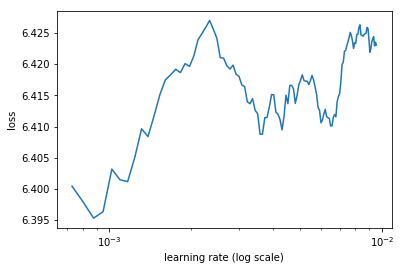

In [57]:
learner.sched.plot()

Start doing a few epochs of the full model

In [58]:
start = timer()
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)
end = timer()
print(f'elapsed: {end - start}')

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      6.363764   6.188202   0.04686   
    1      6.359659   6.19159    0.046905  
    2      6.348705   6.186267   0.046874  
    3      6.21878    5.886193   0.091488  
    4      5.774761   5.490061   0.131883  
    5      5.509296   5.303198   0.151286  
    6      5.344964   5.196895   0.160693  
    7      5.231449   5.114079   0.16873   
    8      5.148436   5.055016   0.174045  
    9      5.076343   5.012696   0.178602  
    10     5.028503   4.975904   0.183761  
    11     4.974692   4.961586   0.184975  
    12     4.940303   4.931555   0.188118  
    13     4.9065     4.915907   0.188738  
    14     4.890351   4.907102   0.189275  

elapsed: 207.95462071899965


This loss compares with Lesson 4 - Academic worlds best in 2017 - aftewr 14 epochs val loss of 4.23. 

Here after 1 epoch on full model we have a 4.12 loss 

ie by pretraining on wikitext103 better loss after 1 epoch than best loss for Lesson 4 2017.

In [59]:
#for full dataset after 5 hrs (on GTX1080Ti):
#14     4.045284   4.072163   0.299391  

#1/50th dataset after 213 seconds (356 seconds on GTX1070):
#14     4.899093   4.919841   0.187322  

#1/100th dataset after 96 seconds:
#14     5.937064   5.737786   0.097723  


In [60]:
learner.save('lm1_mini')

In [61]:
learner.save_encoder('lm1_enc_mini')

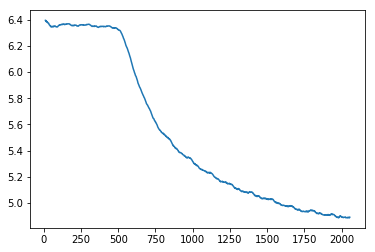

In [62]:
learner.sched.plot_loss()

## Classifier Tokens

In [63]:
df_trn = pd.read_csv(CLAS_PATH/'train_mini.csv', header=None, chunksize=CHUNKSIZE)
df_val = pd.read_csv(CLAS_PATH/'test_mini.csv', header=None, chunksize=CHUNKSIZE)

In [64]:
tok_trn, trn_labels = get_all(tf_reader=df_trn, n_lbls=1)
tok_val, val_labels = get_all(tf_reader=df_trn, n_lbls=1)

0
elapsed: 3.3929726330025005


In [65]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn_mini.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val_mini.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels_mini.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels_mini.npy', val_labels)

In [66]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn_mini.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val_mini.npy')

In [67]:
itos = pickle.load((LM_PATH/'tmp'/'itos_mini.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

9574

In [68]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [69]:
np.save(CLAS_PATH/'tmp'/'trn_ids_mini.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids_mini.npy', val_clas)

## Classifier

In [70]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids_mini.npy')
val_clas =np.load(CLAS_PATH/'tmp'/'trn_ids_mini.npy')

In [71]:
trn_labels = np.load(CLAS_PATH/'tmp'/'trn_labels_mini.npy')
print(f'trn_labels.shape: {trn_labels.shape}')

#Remove single-dimensional entries from the shape of an array.
trn_labels = np.squeeze(trn_labels)
print(f'squeezed trn_labels.shape: {trn_labels.shape}')
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels_mini.npy'))

trn_labels.shape: (1500, 1)
squeezed trn_labels.shape: (1500,)


In [72]:
bptt =70
em_sz = 400
#number of hidden activation per LSTM layer
n_hid= 1150
#number of LSTM layers to use in the architecture
n_layers = 3
vocab_size = len(itos)
bs = 48


In [73]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [74]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
n_class = int(trn_labels.max()) + 1

In [75]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
#extends torch Sampler, appears to do some sorting then randomize batches
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
#note sure is was but in lesson .pynb of if library changed, added bs here
val_samp = SortishSampler(val_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
model_data = ModelData(PATH, trn_dl, val_dl)

In [76]:
#part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [77]:
#dps = np.array([0.4, 0.5, 0.05, 0.3, 0.4])*0.5


get_rnn_classifer() returns SequentialRNN(MultiBatchRNN(RNN_Encoder), PoolingLinearClassifier(layers, drops))

where RNN_Encoder modelled after **Merity et al (2017)**

"In this work, we investigate a set of regularization strategies that are not only highly effective butwhich can also be used with no modification to existing LSTM implementations. The weight-dropped LSTM applies recurrent regulariza- tion through a DropConnectmask on the hidden-to-hidden recurrent weights. Other strategies include the use of randomized-length backpropagation through time (BPTT), embedding dropout, activation regularization (AR), and temporal"

In [79]:
max_seq = 20*70
layers=[em_sz*3, 50, n_class]
drops=[dps[4], 0.1]

#get_rnn_classifer(bptt, max_seq, n_class, n_tok, emb_sz, n_hid, n_layers, pad_token, layers, drops, bidir=False,
#     dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5):
m = get_rnn_classifer(bptt, max_seq, n_class=n_class, n_tok=vocab_size, emb_sz=em_sz, n_hid=n_hid, 
                      n_layers=n_layers, pad_token=1, layers=layers, drops=drops, dropouti=dps[0], 
                      wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [80]:
#why are we changing the optimizer?
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [81]:
#Learning using cross entropy criterion
learn = RNN_Learner(model_data, TextModel(to_gpu(m)), opt_fn=opt_fn)
#seq2seq_reg  regularization, if alphs then mult by a squared fn, beta is temporal activation regularization (slowness)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.0
learn.metrics = [accuracy]

In [87]:
lr = 1e-3
lrm = 2.6
#discriminative weigth decay
#lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [88]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [89]:
#trying out weight decay
#wd = 1e-7
#wd = 0
#learn.load_encoder('lm2_enc_mini')

In [90]:
learn.freeze_to(-1)

In [91]:
learn.lr_find(lrs/1000)
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

IndexError: index 173 is out of bounds for axis 0 with size 0

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

In [ ]:
learn.save('clas_0_mini')

In [ ]:
learn.load('clas_0_mini')

In [ ]:
learn.feeze_to(-2)

In [ ]:
learn.save('clas_1_mini')

In [ ]:
learn.load('clas_1_mini')

In [ ]:
learn.unfeeze()

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('clas_2_mini')